<h1>Testing the numerical matrix generation</h1>

Testing "matrix_building_numerical.py".

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import webbpsf
from astropy.io import fits

os.chdir('../python/')
from config import CONFIG_INI
import util_pastis as util
import webbpsf_imaging as webbim

os.environ['WEBBPSF_PATH'] = CONFIG_INI.get('local', 'webbpsf_data_path')
print('Currenlty running on WebbPSF', webbpsf.version.version)

Currenlty running on WebbPSF 0.8.0


## Testing the code in form of a notebook

In [7]:
# Parameters
resDir = os.path.join(CONFIG_INI.get('local', 'local_data_path'), 'matrix_numerical')

#############################################################
#nb_seg = CONFIG_INI.getint('telescope', 'nb_subapertures')
nb_seg = 5       # just for now, to make testing faster
im_size_e2e = CONFIG_INI.getint('numerical', 'im_size_px_webbpsf')
#im_size_e2e = 128    # just for now, to make testing faster
#############################################################

inner_wa = CONFIG_INI.getint('coronagraph', 'IWA')
outer_wa = CONFIG_INI.getint('coronagraph', 'OWA')
sampling = CONFIG_INI.getfloat('numerical', 'sampling')
fpm = CONFIG_INI.get('coronagraph', 'focal_plane_mask')         # focal plane mask
lyot_stop = CONFIG_INI.get('coronagraph', 'pupil_plane_stop')   # Lyot stop
filter = CONFIG_INI.get('filter', 'name')
nm_aber = CONFIG_INI.getfloat('calibration', 'single_aberration_nm')
wss_segs = webbpsf.constants.SEGNAMES_WSS_ORDER
zern_max = CONFIG_INI.getint('zernikes', 'max_zern')
zern_number = CONFIG_INI.getint('calibration', 'zernike')
zern_mode = util.ZernikeMode(zern_number)                       # Create Zernike mode object for easier handling
wss_zern_nb = util.noll_to_wss(zern_number)                     # Convert from Noll to WSS framework

Some preliminary checking of the read-in parameters:

In [3]:
print('resDir:', resDir)
print('nb_seg:', nb_seg)
print('im_size_e2e:', im_size_e2e)
print('inner_wa:', inner_wa)
print('outer_wa:', outer_wa)
print('sampling:', sampling)
print('fpm:', fpm)
print('lyot_stop:', lyot_stop)
print('filter:', filter)
print('nm_aber:', nm_aber)
print('wss_segs:', wss_segs)
print('zern_max:', zern_max)
print('zern_number:', zern_number)
print(zern_mode.get_info())
print('wss_zern_nb:', wss_zern_nb)

resDir: /Users/ilaginja/Documents/data_from_repos/pastis_data/matrix_numerical
nb_seg: 2
im_size_e2e: 320
inner_wa: 6
outer_wa: 10
sampling: 2.0
fpm: MASK335R
lyot_stop: CIRCLYOT
filter: F335M
nm_aber: 100.0
wss_segs: ('A1-1', 'A2-2', 'A3-3', 'A4-4', 'A5-5', 'A6-6', 'B1-7', 'C1-8', 'B2-9', 'C2-10', 'B3-11', 'C3-12', 'B4-13', 'C4-14', 'B5-15', 'C5-16', 'B6-17', 'C6-18')
zern_max: 11
zern_number: 1
This is Zernike mode 1 in the Noll convention, which is: piston
None
wss_zern_nb: 1


### Create a direct E2E PSF to obtain normalization factor

Pysynphot unavailable (or invalid source supplied)!   Assuming flat # of counts versus wavelength.
CAUTION: Just interpolating rather than integrating filter profile, over 1 steps


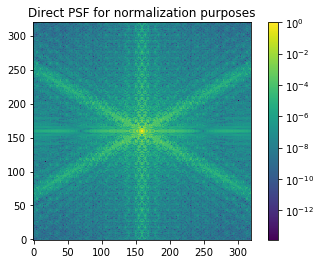

PSf shape: (320, 320)
PSF max: 1.0


In [4]:
Aber_WSS = np.zeros([nb_seg, zern_max])

# Create NIRCam object
nc = webbpsf.NIRCam()
# Set filter
nc.filter = filter

# Adjust OTE with aberrations
nc, ote = webbpsf.enable_adjustable_ote(nc)
nc.include_si_wfe = False  # set SI internal WFE to zero
ote.reset()
ote.zero()
for i in range(nb_seg):
    seg = wss_segs[i].split('-')[0]
    ote._apply_hexikes_to_seg(seg, Aber_WSS[i,:])

# Calculate PSF
psf_nc = nc.calc_psf(oversample=1, fov_pixels=int(im_size_e2e), nlambda=1)
psf_perfect = psf_nc[1].data

# Normalize PSF
normp = np.max(psf_perfect)
psf_perfect = psf_perfect / normp

# Show PSF
plt.imshow(psf_perfect, norm=LogNorm(), origin='lower')
plt.title('Direct PSF for normalization purposes')
plt.colorbar()
plt.show()

print('PSf shape:', psf_perfect.shape)
print('PSF max:', np.max(psf_perfect))

### Create a dark hole mask

Creating a dark hole mask so that we can later overlay it with the images to extract the average contrast.

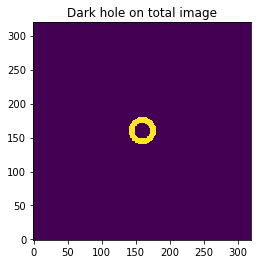

In [5]:
# Create the dark hole mask.
pup_im = np.zeros([im_size_e2e, im_size_e2e])    # this is just used for DH mask generation
dh_area = util.create_dark_hole(pup_im, inner_wa, outer_wa, sampling)

plt.imshow(dh_area)
plt.title('Dark hole on total image')
plt.show()

### Create NIRCam object with coronagraph

Setting up the webbpsf NIRCam object which we will control to move different segment pairs at a time and then generate an image.

Pysynphot unavailable (or invalid source supplied)!   Assuming flat # of counts versus wavelength.
CAUTION: Just interpolating rather than integrating filter profile, over 9 steps


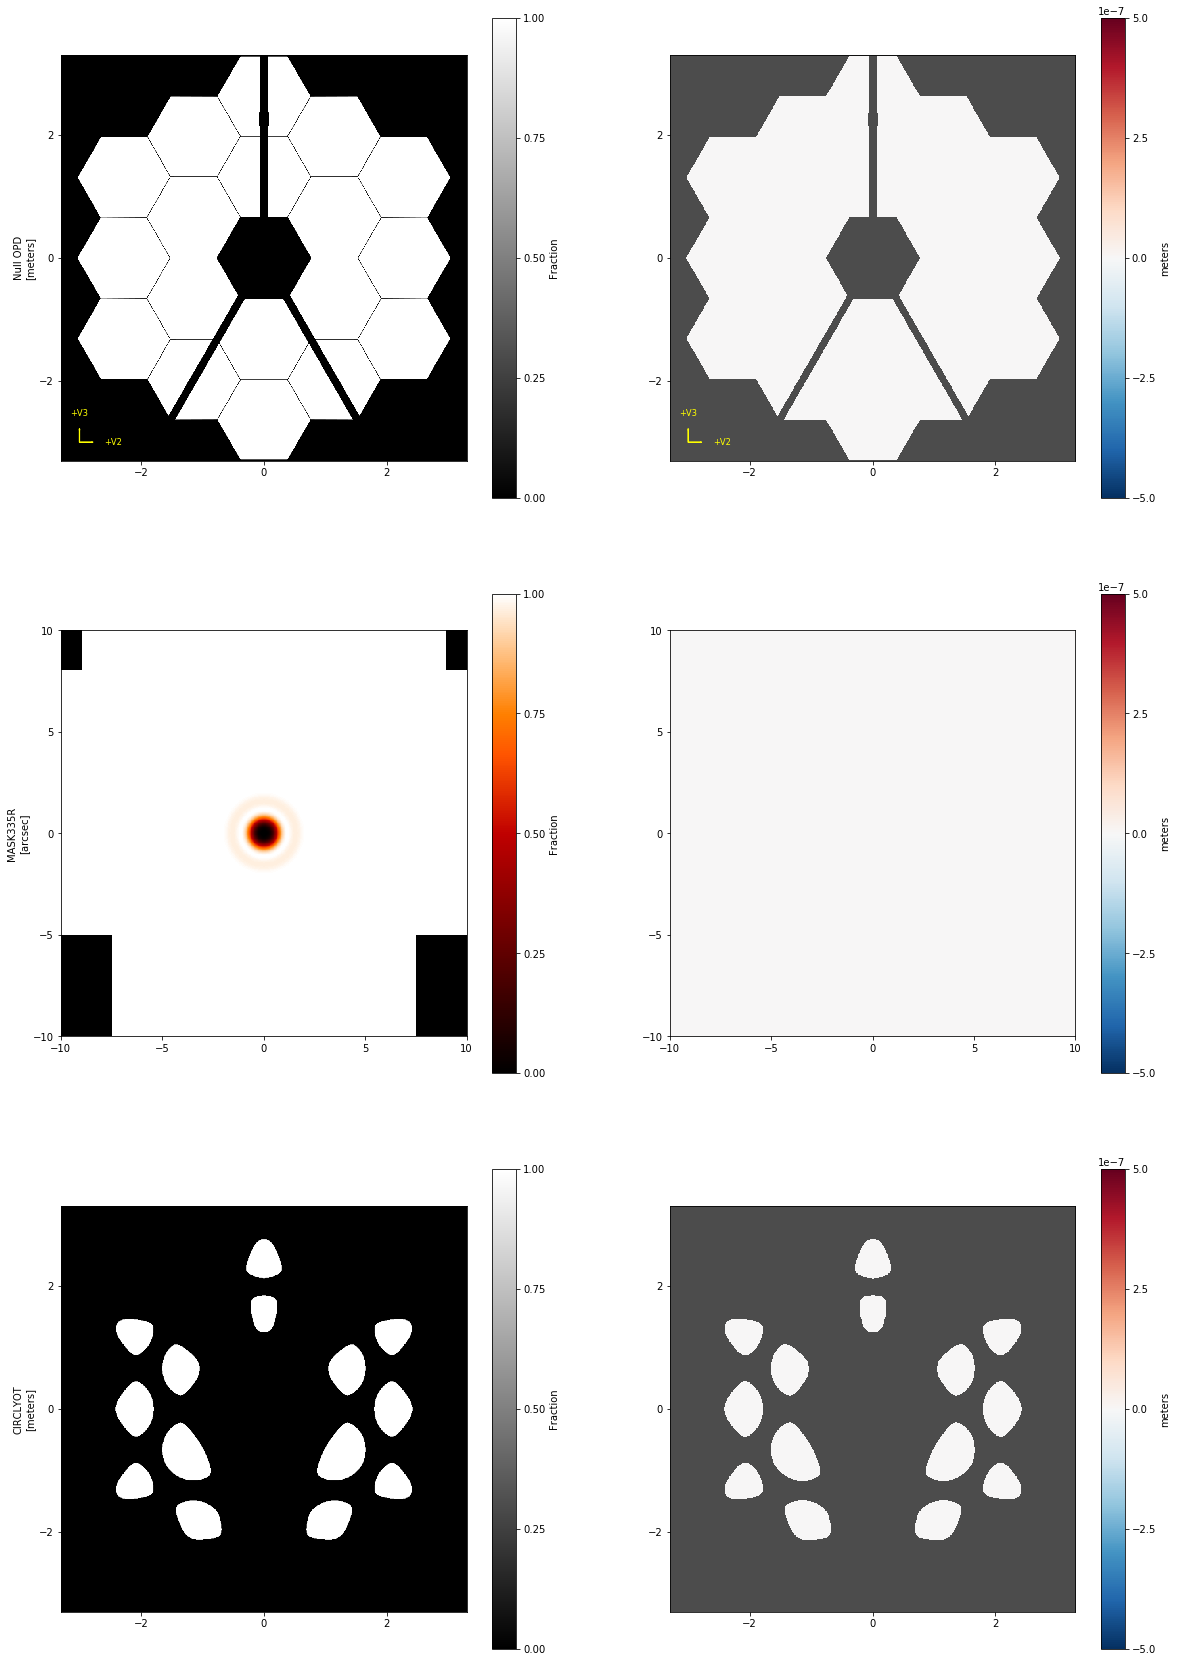

In [6]:
# Set up NIRCam object from WebbPSF
nc_coro = webbpsf.NIRCam()
nc_coro.filter = filter
nc_coro.image_mask = fpm
nc_coro.pupil_mask = lyot_stop

# Null the OTE OPDs for the PSFs, maybe we will add internal WFE later.
nc_coro, ote_coro = webbpsf.enable_adjustable_ote(nc_coro)      # create OTE for coronagraph
ote_coro.zero()                       # Delete the OTE OPD
nc_coro.include_si_wfe= False         # set SI internal WFE to zero

plt.figure(figsize=(20, 30))
nc_coro.display()
plt.show()

### Generate numerical PASTIS matrix

Next, making the loop to generate one image per aberrated segment pair i, j and feeding the resulting contrast into the matrix element [i, j].

STEP: 1-1 / 5-5


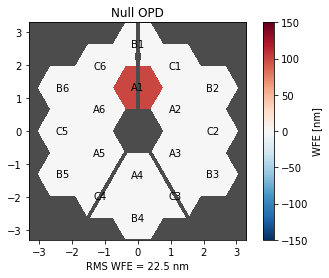

Pysynphot unavailable (or invalid source supplied)!   Assuming flat # of counts versus wavelength.
CAUTION: Just interpolating rather than integrating filter profile, over 1 steps


Calculating WebbPSF image
Calculating mean contrast in dark hole
contrast: 3.7143619094e-08


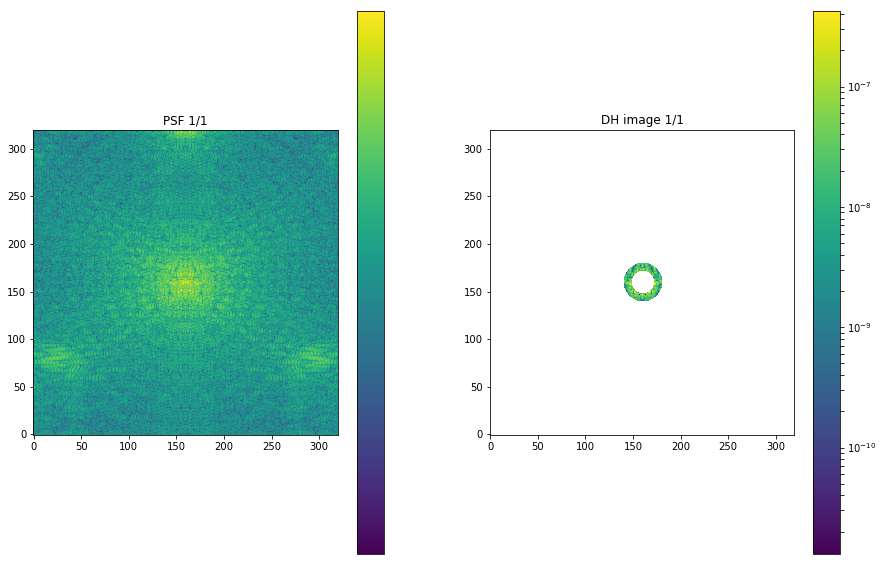

STEP: 1-2 / 5-5


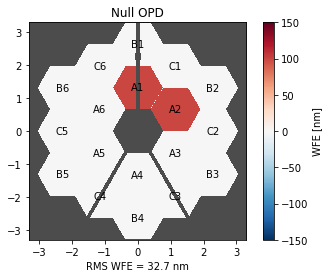

Pysynphot unavailable (or invalid source supplied)!   Assuming flat # of counts versus wavelength.
CAUTION: Just interpolating rather than integrating filter profile, over 1 steps


Calculating WebbPSF image
Calculating mean contrast in dark hole
contrast: 8.86339897902e-08


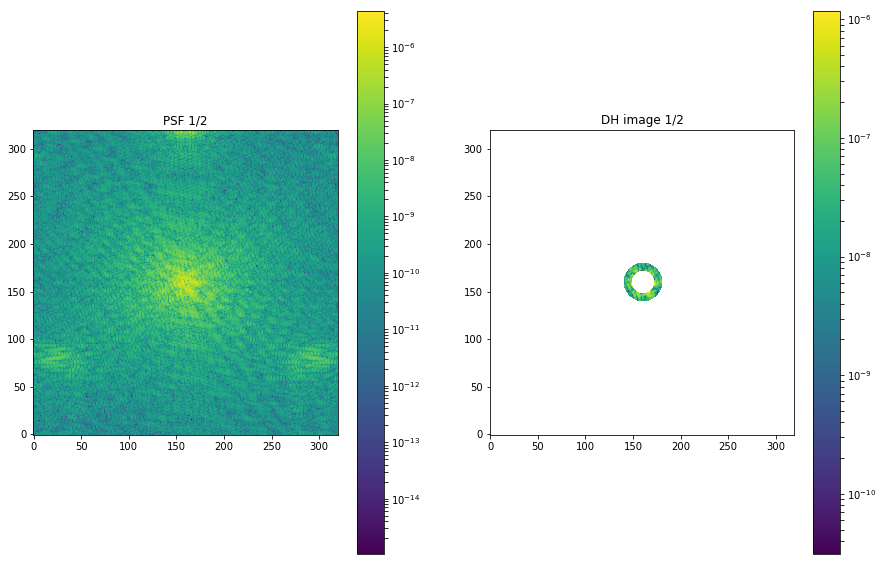

STEP: 1-3 / 5-5


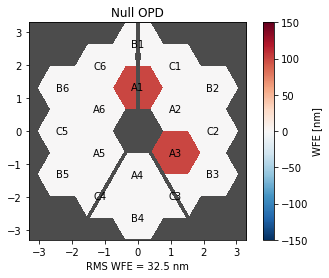

Pysynphot unavailable (or invalid source supplied)!   Assuming flat # of counts versus wavelength.
CAUTION: Just interpolating rather than integrating filter profile, over 1 steps


Calculating WebbPSF image
Calculating mean contrast in dark hole
contrast: 7.57455340944e-08


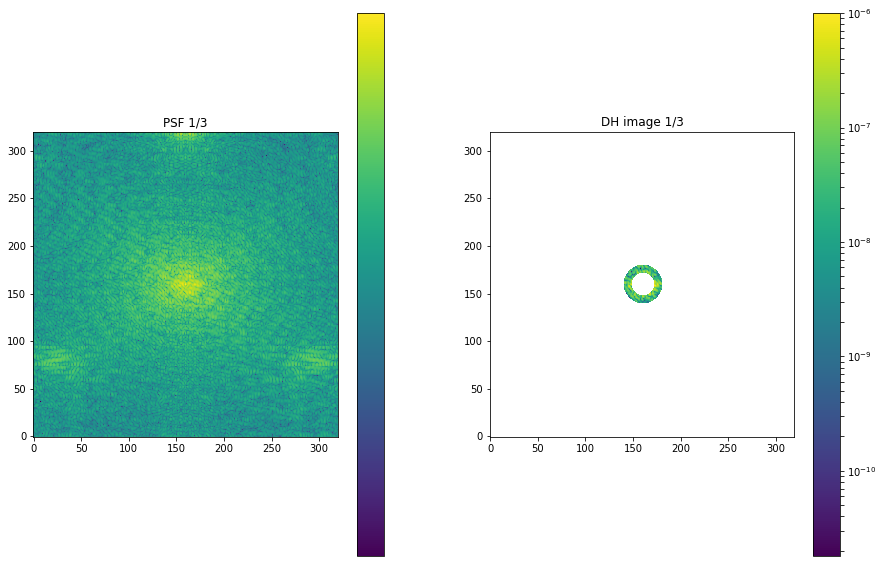

STEP: 1-4 / 5-5


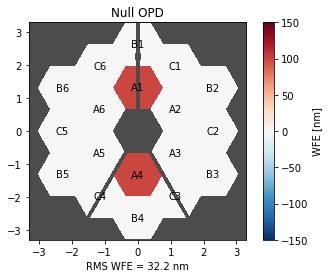

Pysynphot unavailable (or invalid source supplied)!   Assuming flat # of counts versus wavelength.
CAUTION: Just interpolating rather than integrating filter profile, over 1 steps


Calculating WebbPSF image
Calculating mean contrast in dark hole
contrast: 6.80911565351e-08


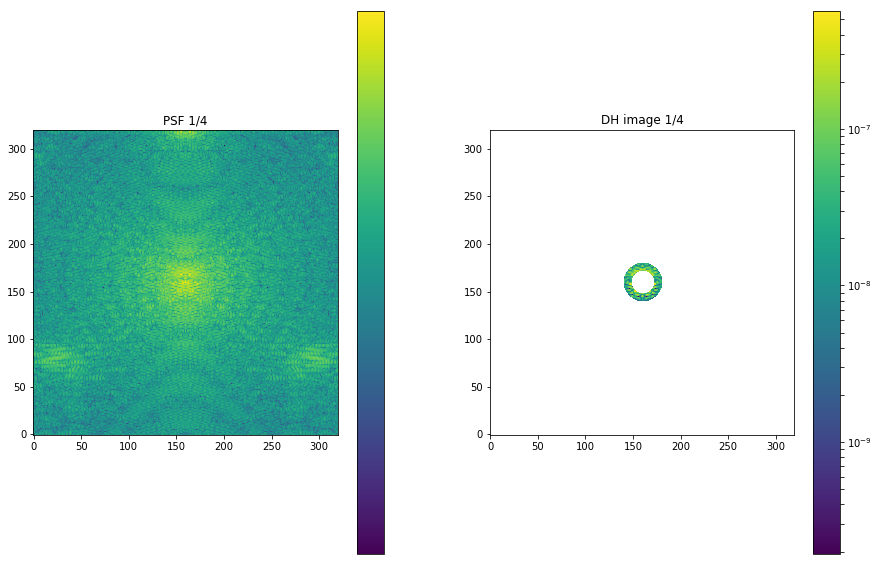

STEP: 1-5 / 5-5


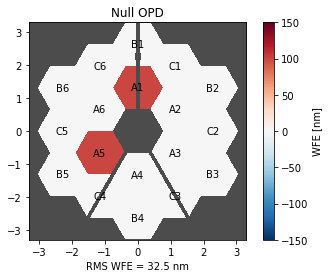

Pysynphot unavailable (or invalid source supplied)!   Assuming flat # of counts versus wavelength.
CAUTION: Just interpolating rather than integrating filter profile, over 1 steps


Calculating WebbPSF image
Calculating mean contrast in dark hole
contrast: 7.72405774382e-08


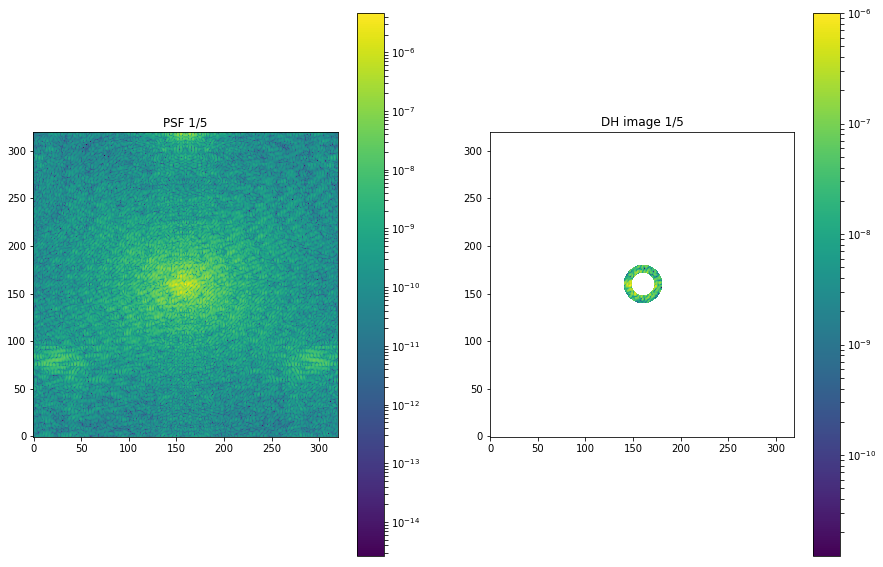

STEP: 2-1 / 5-5


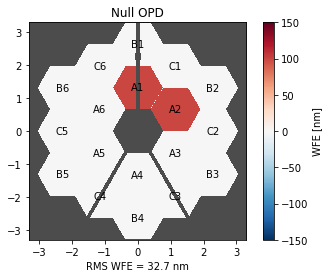

Pysynphot unavailable (or invalid source supplied)!   Assuming flat # of counts versus wavelength.
CAUTION: Just interpolating rather than integrating filter profile, over 1 steps


Calculating WebbPSF image
Calculating mean contrast in dark hole
contrast: 8.86339897902e-08


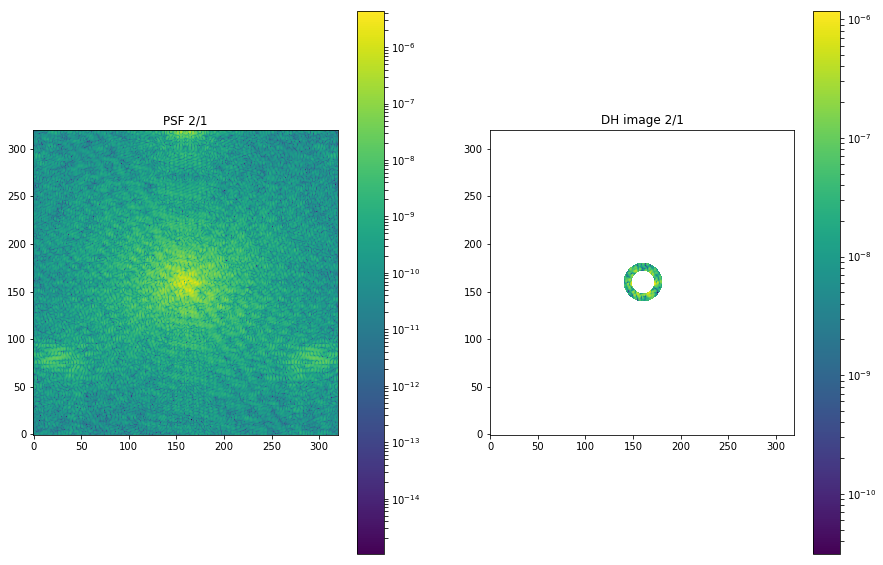

STEP: 2-2 / 5-5


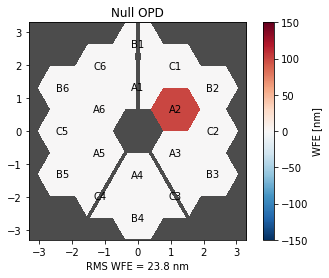

Pysynphot unavailable (or invalid source supplied)!   Assuming flat # of counts versus wavelength.
CAUTION: Just interpolating rather than integrating filter profile, over 1 steps


Calculating WebbPSF image
Calculating mean contrast in dark hole
contrast: 8.02914080226e-08


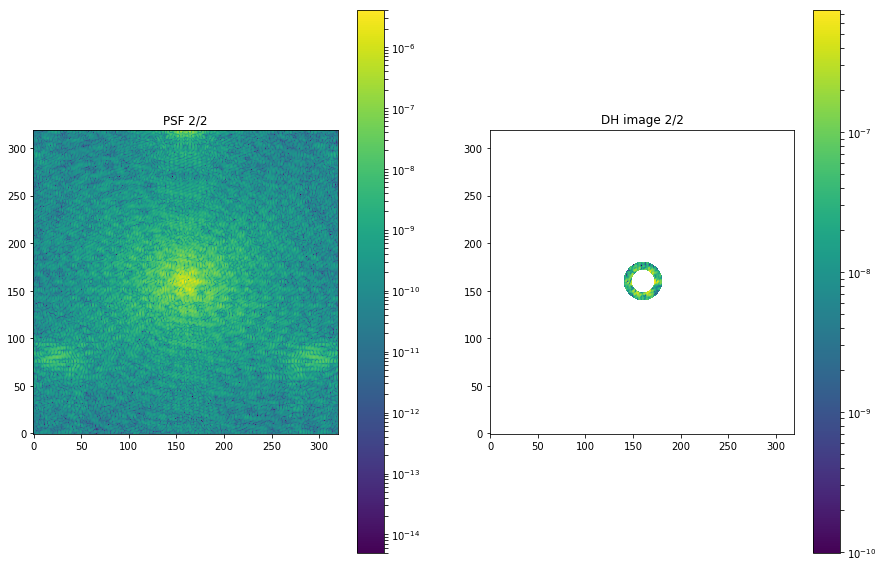

STEP: 2-3 / 5-5


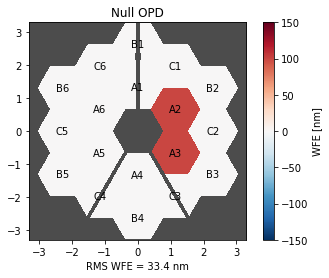

Pysynphot unavailable (or invalid source supplied)!   Assuming flat # of counts versus wavelength.
CAUTION: Just interpolating rather than integrating filter profile, over 1 steps


Calculating WebbPSF image
Calculating mean contrast in dark hole
contrast: 1.0957309871e-07


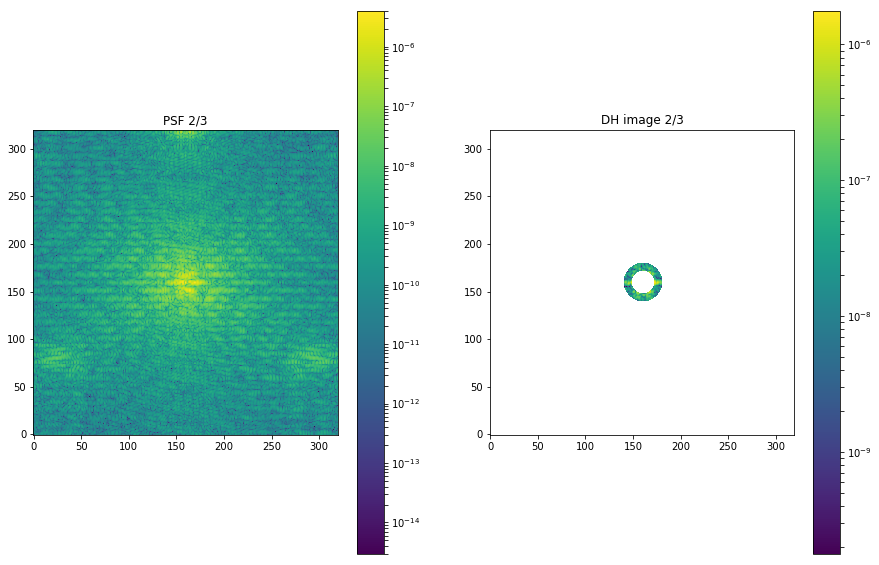

STEP: 2-4 / 5-5


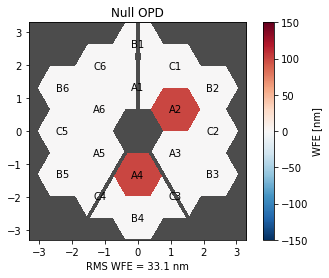

Pysynphot unavailable (or invalid source supplied)!   Assuming flat # of counts versus wavelength.
CAUTION: Just interpolating rather than integrating filter profile, over 1 steps


Calculating WebbPSF image
Calculating mean contrast in dark hole
contrast: 1.10603396391e-07


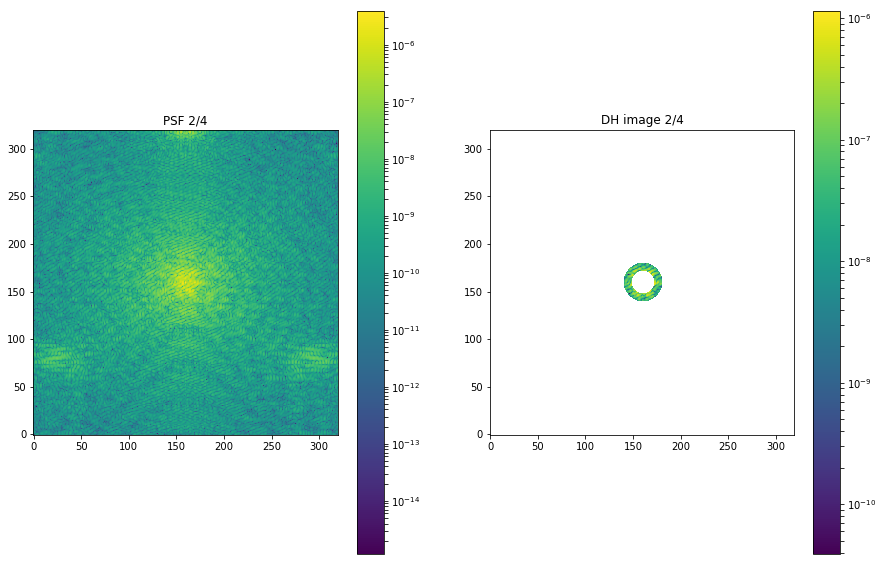

STEP: 2-5 / 5-5


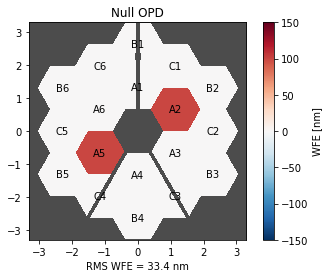

Pysynphot unavailable (or invalid source supplied)!   Assuming flat # of counts versus wavelength.
CAUTION: Just interpolating rather than integrating filter profile, over 1 steps


Calculating WebbPSF image
Calculating mean contrast in dark hole
contrast: 1.18249204133e-07


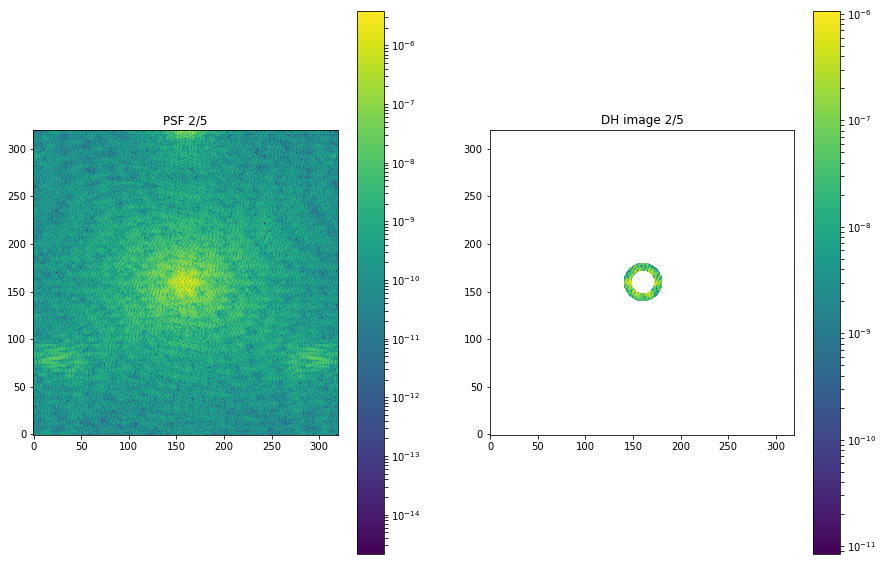

STEP: 3-1 / 5-5


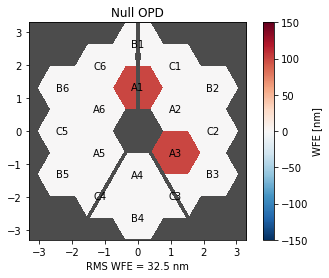

Pysynphot unavailable (or invalid source supplied)!   Assuming flat # of counts versus wavelength.
CAUTION: Just interpolating rather than integrating filter profile, over 1 steps


Calculating WebbPSF image
Calculating mean contrast in dark hole
contrast: 7.57455340944e-08


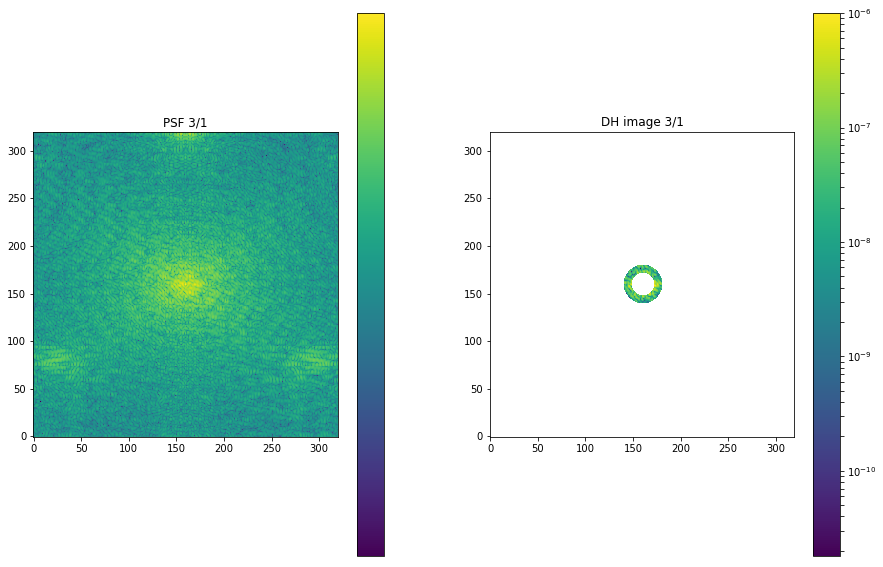

STEP: 3-2 / 5-5


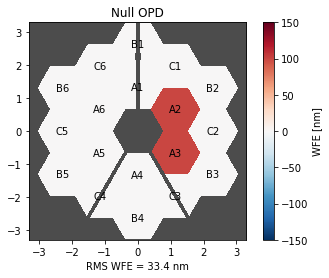

Pysynphot unavailable (or invalid source supplied)!   Assuming flat # of counts versus wavelength.
CAUTION: Just interpolating rather than integrating filter profile, over 1 steps


Calculating WebbPSF image
Calculating mean contrast in dark hole
contrast: 1.0957309871e-07


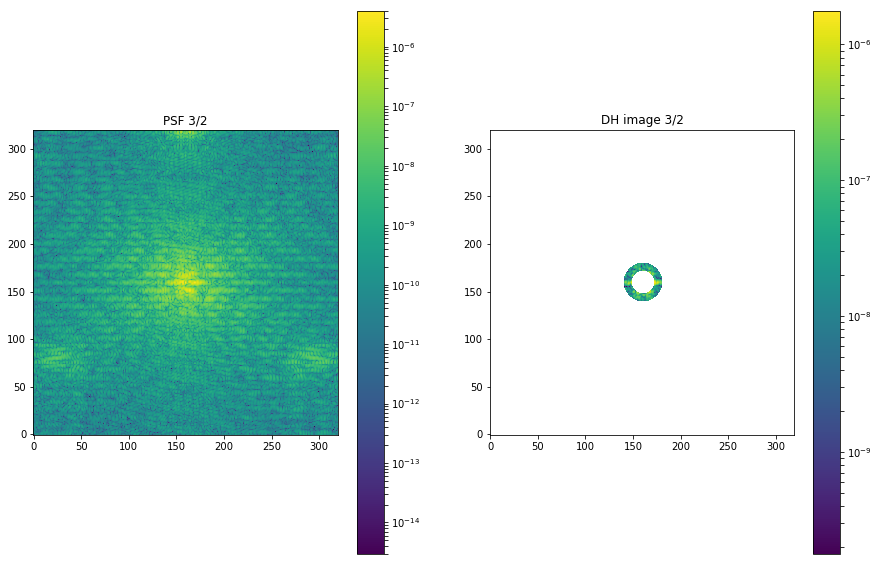

STEP: 3-3 / 5-5


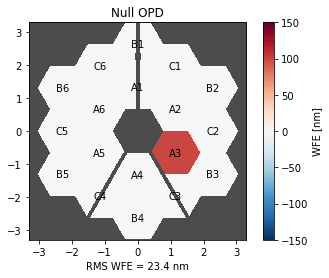

Pysynphot unavailable (or invalid source supplied)!   Assuming flat # of counts versus wavelength.
CAUTION: Just interpolating rather than integrating filter profile, over 1 steps


Calculating WebbPSF image
Calculating mean contrast in dark hole
contrast: 6.07133084864e-08


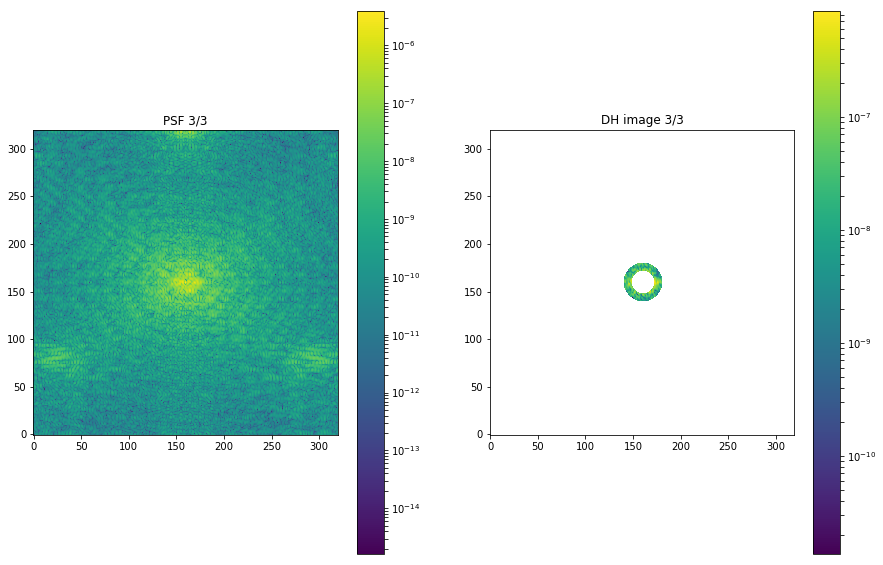

STEP: 3-4 / 5-5


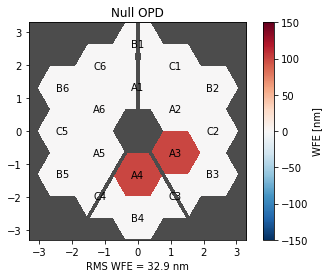

Pysynphot unavailable (or invalid source supplied)!   Assuming flat # of counts versus wavelength.
CAUTION: Just interpolating rather than integrating filter profile, over 1 steps


Calculating WebbPSF image
Calculating mean contrast in dark hole
contrast: 9.44618502446e-08


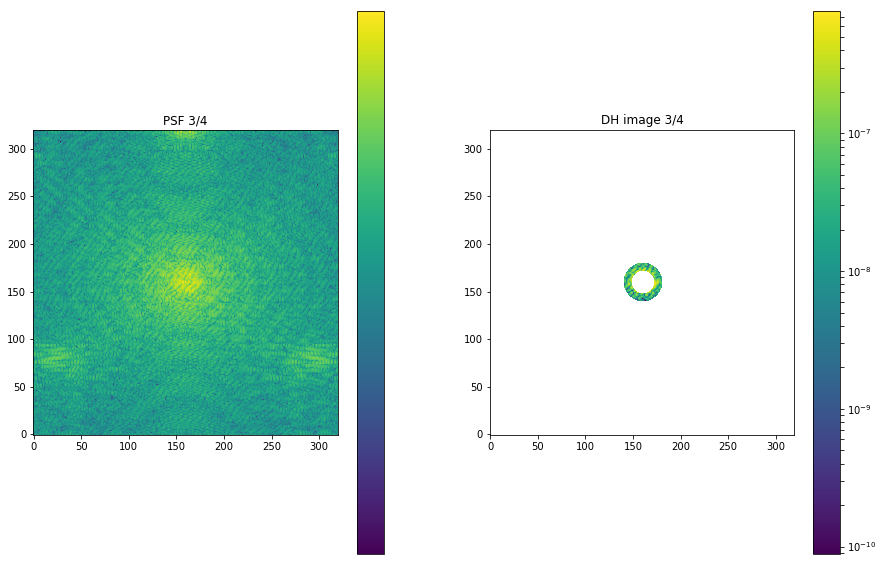

STEP: 3-5 / 5-5


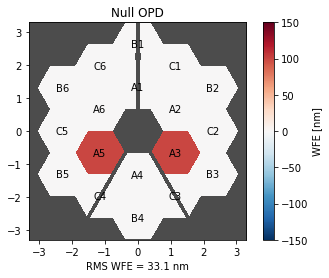

Pysynphot unavailable (or invalid source supplied)!   Assuming flat # of counts versus wavelength.
CAUTION: Just interpolating rather than integrating filter profile, over 1 steps


Calculating WebbPSF image
Calculating mean contrast in dark hole
contrast: 1.00077925294e-07


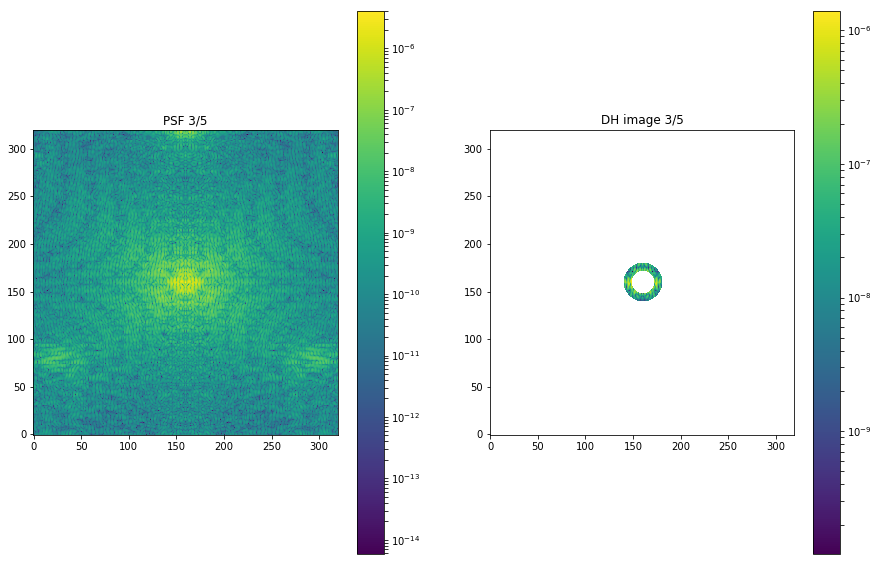

STEP: 4-1 / 5-5


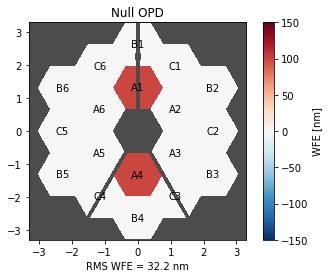

Pysynphot unavailable (or invalid source supplied)!   Assuming flat # of counts versus wavelength.
CAUTION: Just interpolating rather than integrating filter profile, over 1 steps


Calculating WebbPSF image
Calculating mean contrast in dark hole
contrast: 6.80911565351e-08


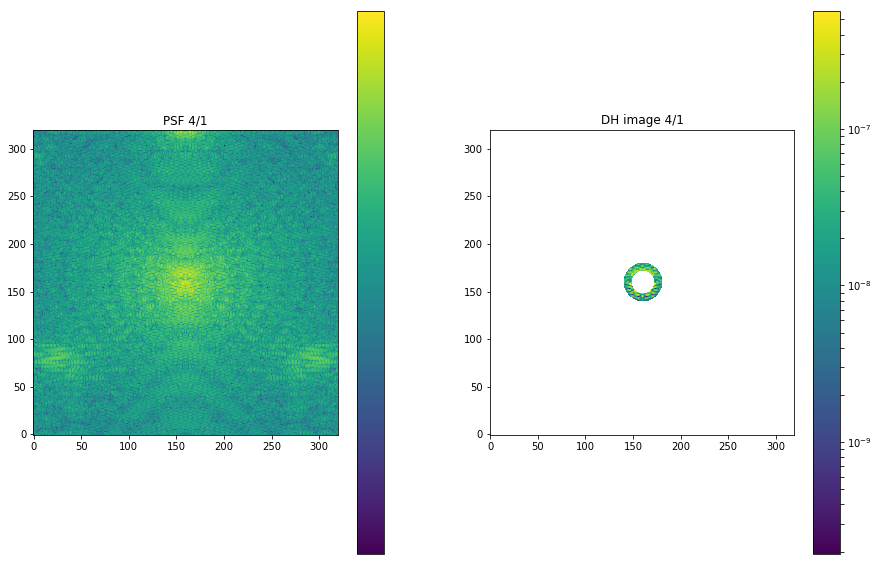

STEP: 4-2 / 5-5


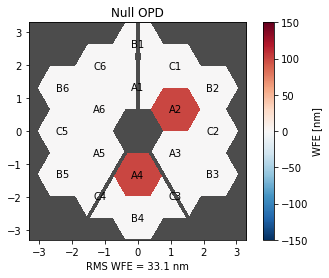

Pysynphot unavailable (or invalid source supplied)!   Assuming flat # of counts versus wavelength.
CAUTION: Just interpolating rather than integrating filter profile, over 1 steps


Calculating WebbPSF image
Calculating mean contrast in dark hole
contrast: 1.10603396391e-07


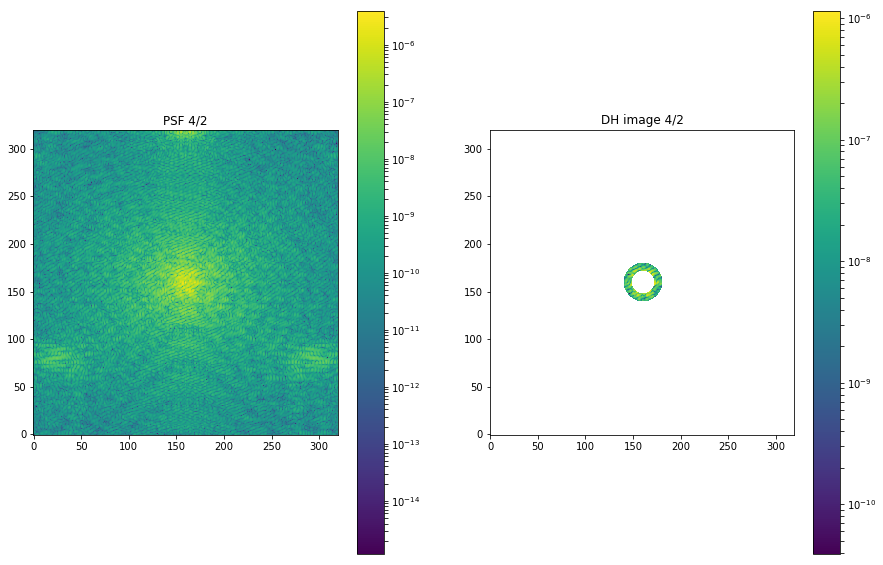

STEP: 4-3 / 5-5


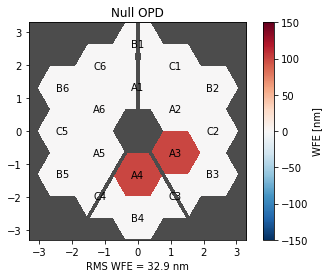

Pysynphot unavailable (or invalid source supplied)!   Assuming flat # of counts versus wavelength.
CAUTION: Just interpolating rather than integrating filter profile, over 1 steps


Calculating WebbPSF image
Calculating mean contrast in dark hole
contrast: 9.44618502446e-08


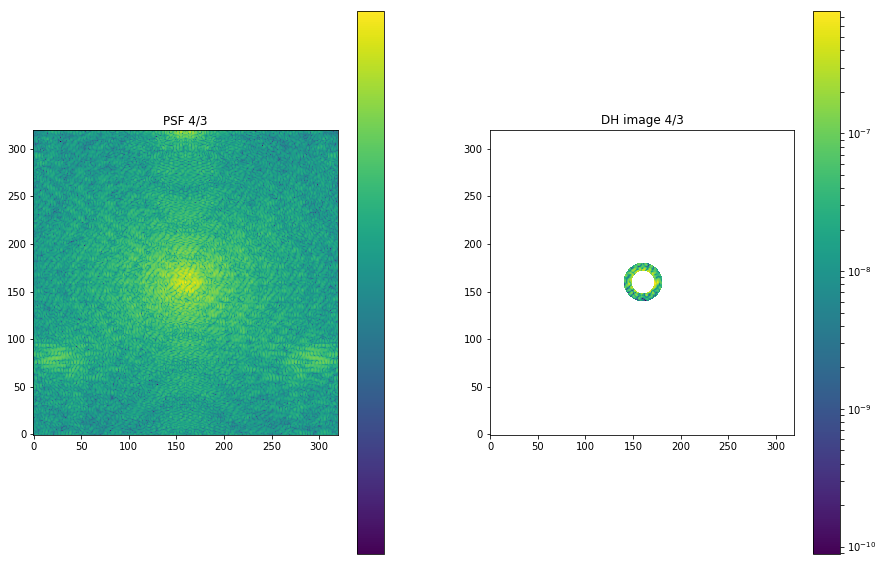

STEP: 4-4 / 5-5


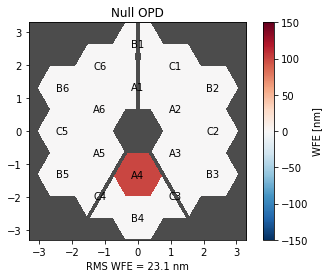

Pysynphot unavailable (or invalid source supplied)!   Assuming flat # of counts versus wavelength.
CAUTION: Just interpolating rather than integrating filter profile, over 1 steps


Calculating WebbPSF image
Calculating mean contrast in dark hole
contrast: 5.38174632314e-08


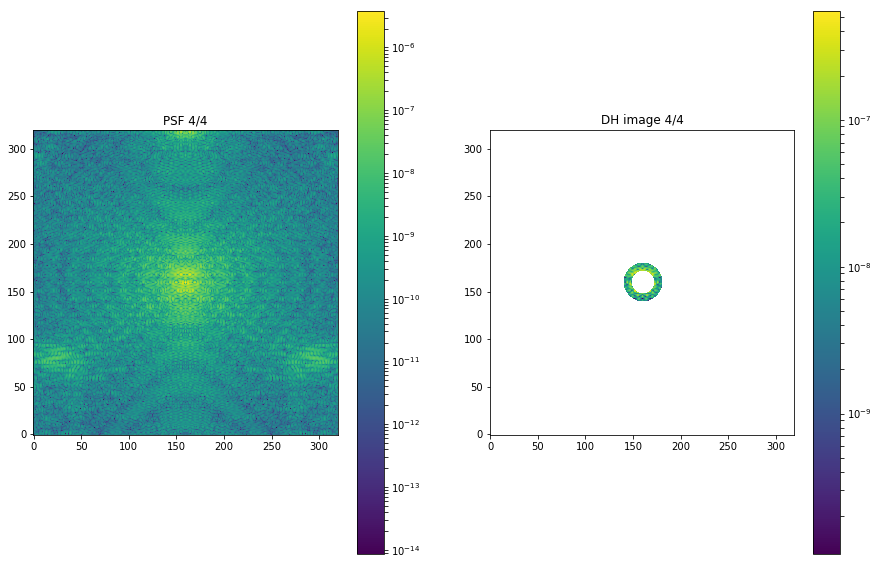

STEP: 4-5 / 5-5


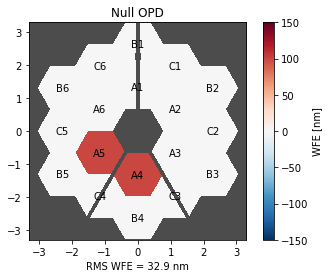

Pysynphot unavailable (or invalid source supplied)!   Assuming flat # of counts versus wavelength.
CAUTION: Just interpolating rather than integrating filter profile, over 1 steps


Calculating WebbPSF image
Calculating mean contrast in dark hole
contrast: 9.56193006504e-08


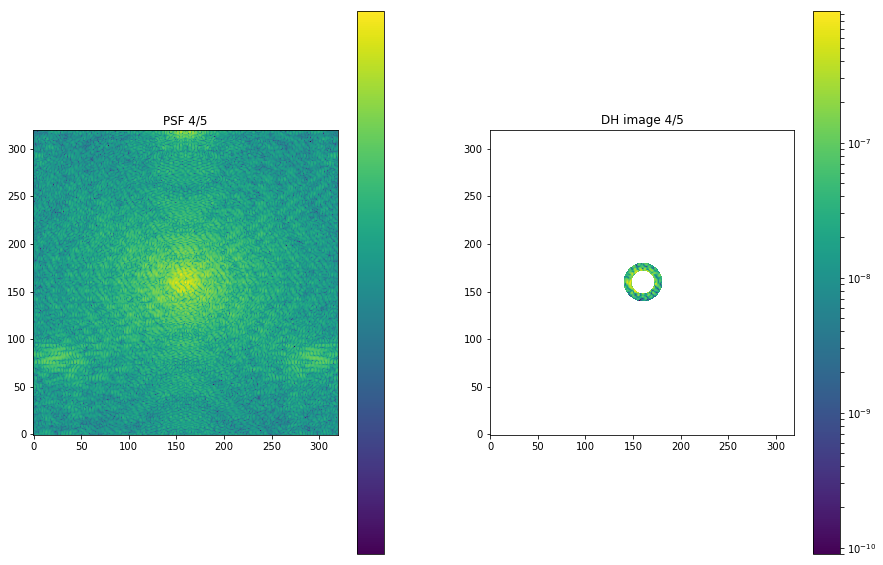

STEP: 5-1 / 5-5


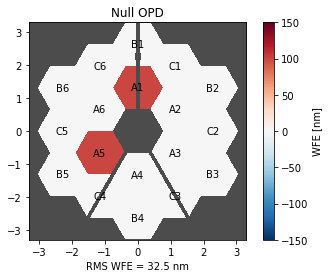

Pysynphot unavailable (or invalid source supplied)!   Assuming flat # of counts versus wavelength.
CAUTION: Just interpolating rather than integrating filter profile, over 1 steps


Calculating WebbPSF image
Calculating mean contrast in dark hole
contrast: 7.72405774382e-08


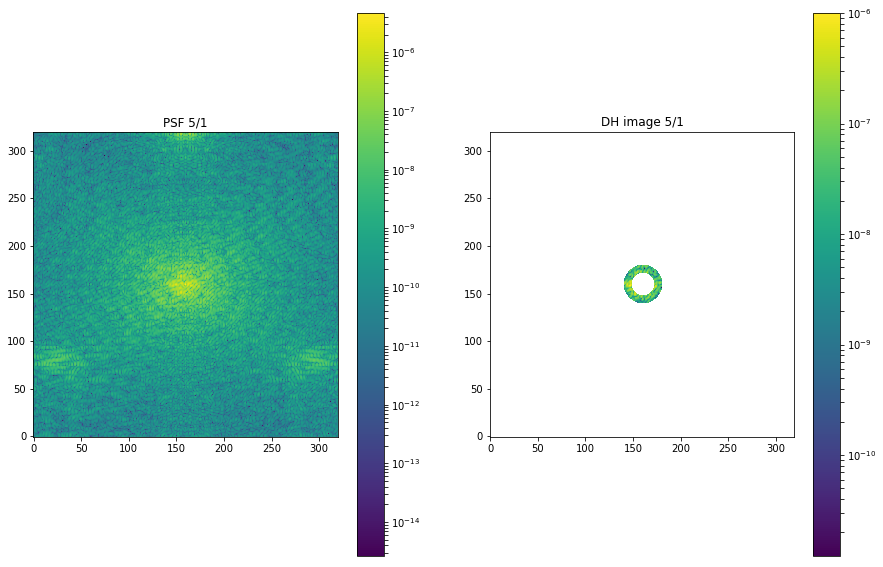

STEP: 5-2 / 5-5


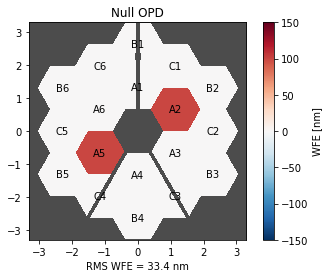

Pysynphot unavailable (or invalid source supplied)!   Assuming flat # of counts versus wavelength.
CAUTION: Just interpolating rather than integrating filter profile, over 1 steps


Calculating WebbPSF image
Calculating mean contrast in dark hole
contrast: 1.18249204133e-07


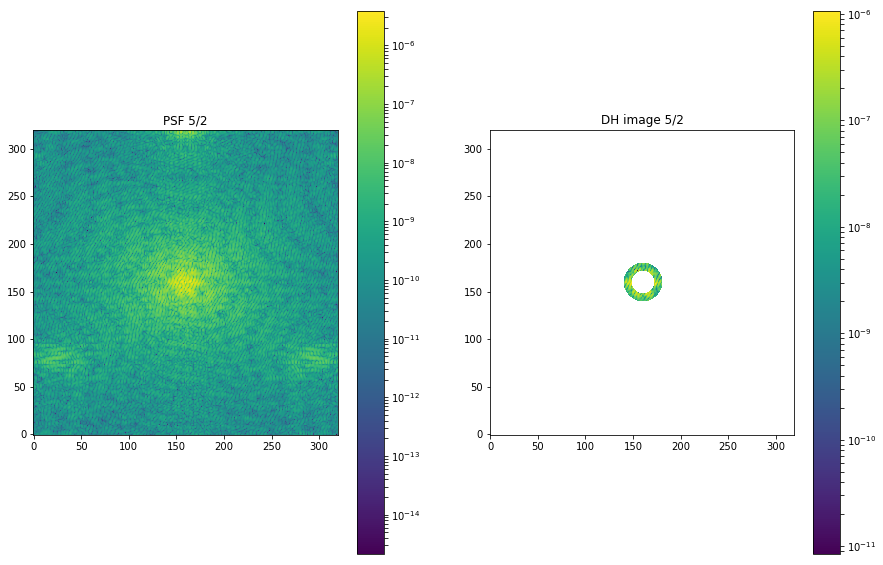

STEP: 5-3 / 5-5


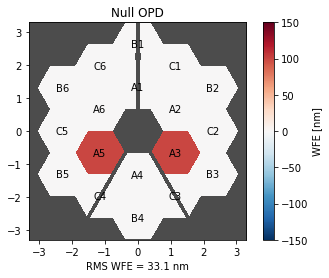

Pysynphot unavailable (or invalid source supplied)!   Assuming flat # of counts versus wavelength.
CAUTION: Just interpolating rather than integrating filter profile, over 1 steps


Calculating WebbPSF image
Calculating mean contrast in dark hole
contrast: 1.00077925294e-07


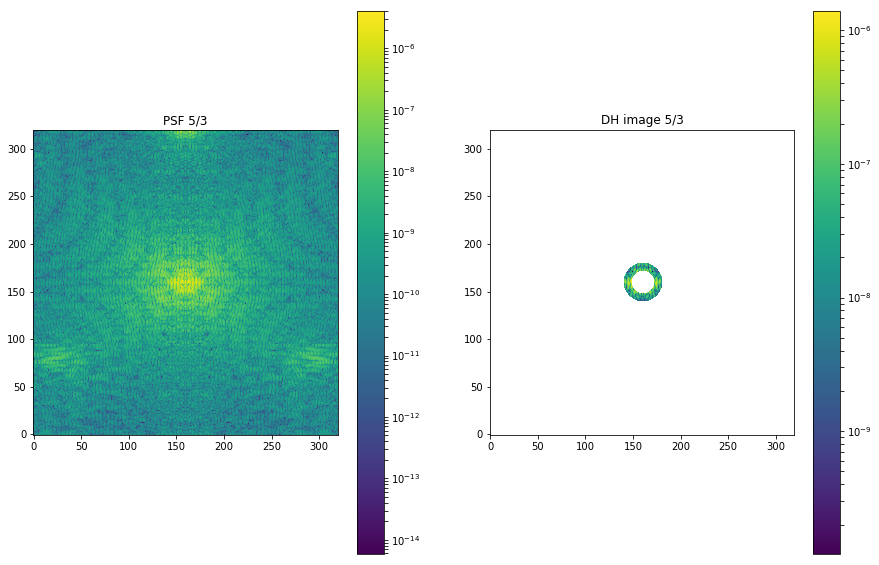

STEP: 5-4 / 5-5


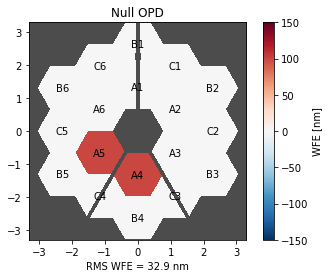

Pysynphot unavailable (or invalid source supplied)!   Assuming flat # of counts versus wavelength.
CAUTION: Just interpolating rather than integrating filter profile, over 1 steps


Calculating WebbPSF image
Calculating mean contrast in dark hole
contrast: 9.56193006504e-08


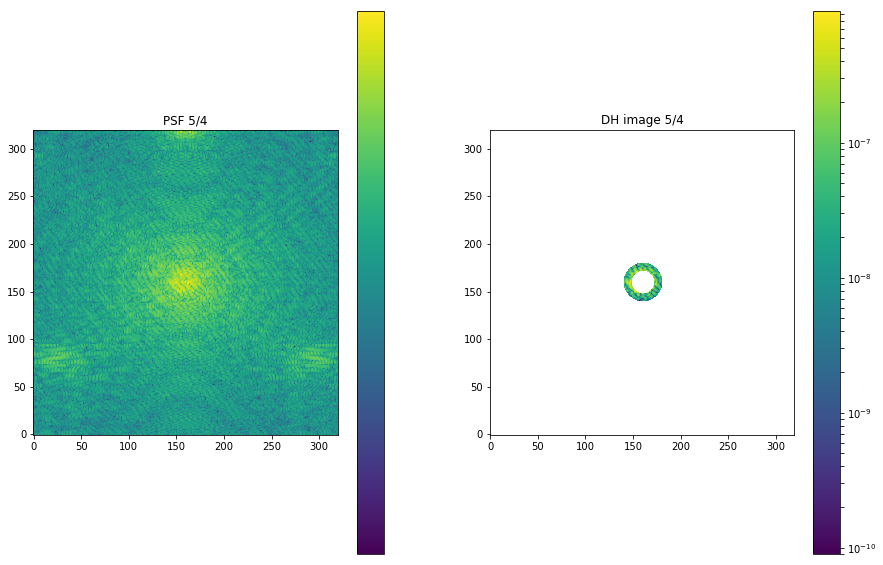

STEP: 5-5 / 5-5


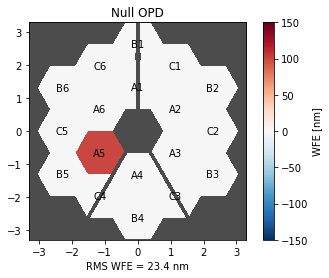

Pysynphot unavailable (or invalid source supplied)!   Assuming flat # of counts versus wavelength.
CAUTION: Just interpolating rather than integrating filter profile, over 1 steps


Calculating WebbPSF image
Calculating mean contrast in dark hole
contrast: 6.24125996831e-08


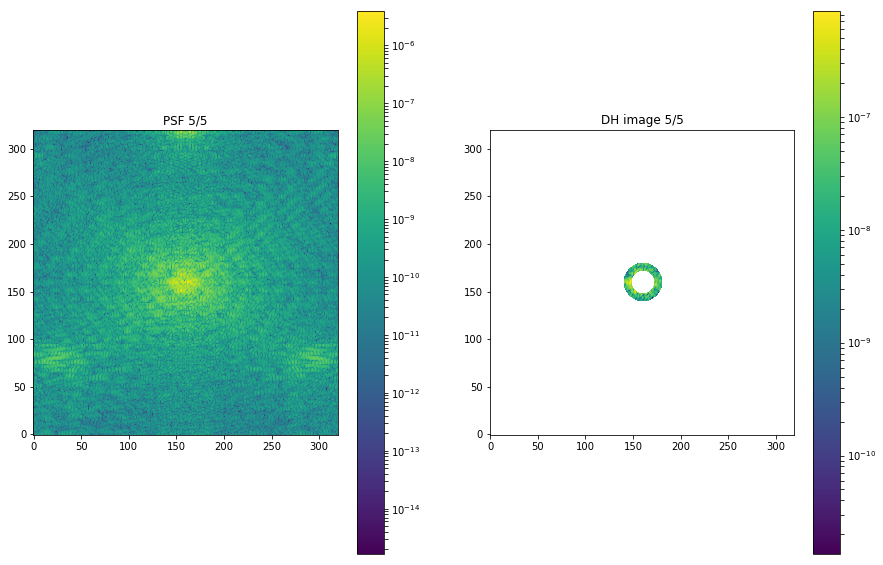

In [8]:
#-# Generating the PASTIS matrix
matrix_direct = np.zeros([nb_seg, nb_seg])   # Generate empty matrix

# List for saving PSFs and DHs and contrasts
all_psfs = []
all_dhs = []
all_contrasts = []

for i in range(nb_seg):
    for j in range(nb_seg):

        print('STEP:', str(i+1) + '-' + str(j+1), '/', str(nb_seg) + '-' + str(nb_seg))
        
        # Get names of segments
        seg_i = wss_segs[i].split('-')[0]
        seg_j = wss_segs[j].split('-')[0]

        # Put the aberration on the correct segments
        Aber_WSS = np.zeros([nb_seg, zern_max])         # The Zernikes here will be filled in the WSS order!!!
                                                        # Because it goes into _apply_hexikes_to_seg().
        Aber_WSS[i, wss_zern_nb - 1] = nm_aber / 1e9    # Aberration on the segment we're currently working on;
                                                        # convert to meters; -1 on the Zernike because Python starts
                                                        # numbering at 0.
        Aber_WSS[j, wss_zern_nb - 1] = nm_aber / 1e9    # same for other segment

        # Putting aberrations on segments i and j
        ote_coro.reset()    # Making sure there are no previous movements on the segments.
        ote_coro.zero()     # set OTE for coronagraph to zero
        
        # Apply both aberrations to OTE. If i=j, apply only once!
        ote_coro._apply_hexikes_to_seg(seg_i, Aber_WSS[i, :])    # set segment i (segment numbering starts at 1)
        if i != j:
            ote_coro._apply_hexikes_to_seg(seg_j, Aber_WSS[j, :])    # set segment j

        # If you want to display teh OTE
        ote_coro.display_opd()
        plt.show()
        
        print('Calculating WebbPSF image')
        image = nc_coro.calc_psf(fov_pixels=int(im_size_e2e), oversample=1, nlambda=1)
        psf = image[0].data/normp
        all_psfs.append(psf)
        
        print('Calculating mean contrast in dark hole')
        dh_intensity = psf * dh_area
        contrast = np.mean(dh_intensity[np.where(dh_intensity != 0)])
        print('contrast:', contrast)
        all_dhs.append(dh_intensity)
        all_contrasts.append(contrast)
        
        # If you want to display the PSF and DH image
        plt.figure(figsize=(15,10))
        plt.subplot(1, 2, 1)
        plt.imshow(psf, norm=LogNorm(), origin='lower')
        plt.colorbar()
        plt.title('PSF ' + str(i+1) + '/' + str(j+1))
        plt.subplot(1, 2, 2)
        plt.imshow(dh_intensity, norm=LogNorm(), origin='lower')
        plt.colorbar()
        plt.title('DH image ' + str(i+1) + '/' + str(j+1))
        plt.show()

        # Fill according entry in the matrix
        matrix_direct[i,j] = contrast
        
all_psfs = np.array(all_psfs)
all_dhs = np.array(all_dhs)
all_contrasts = np.array(all_contrasts)

In [9]:
# Print the contrast values
print('Measured mean contrasts in the dark holes:')
print(all_contrasts)
print('Mean:', np.mean(all_contrasts))
print('Min:', np.min(all_contrasts))
print('Max:', np.max(all_contrasts))

Measured mean contrasts in the dark holes:
[  3.71436191e-08   8.86339898e-08   7.57455341e-08   6.80911565e-08
   7.72405774e-08   8.86339898e-08   8.02914080e-08   1.09573099e-07
   1.10603396e-07   1.18249204e-07   7.57455341e-08   1.09573099e-07
   6.07133085e-08   9.44618502e-08   1.00077925e-07   6.80911565e-08
   1.10603396e-07   9.44618502e-08   5.38174632e-08   9.56193007e-08
   7.72405774e-08   1.18249204e-07   1.00077925e-07   9.56193007e-08
   6.24125997e-08]
Mean: 8.68388186031e-08
Min: 3.7143619094e-08
Max: 1.18249204133e-07


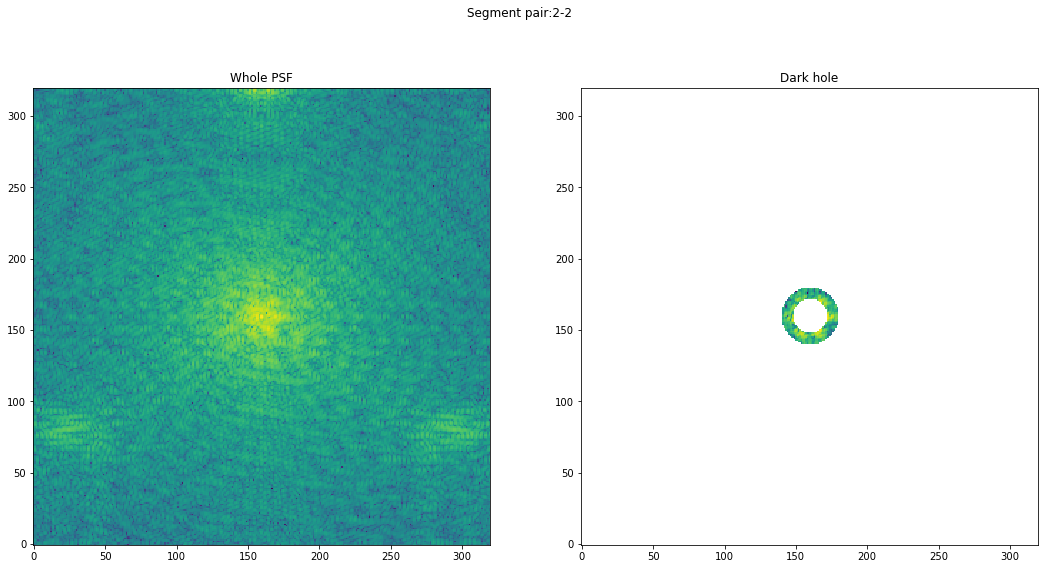

In [10]:
# You can flick through the images here
imnum1 = 6

# Figure out what segment pair the number "imnum" corresponds to
seg1 = int(np.floor(imnum1/nb_seg)) + 1
seg2 = imnum1%nb_seg + 1

plt.figure(figsize=(18, 9))
plt.suptitle('Segment pair:' + str(seg1) + '-' + str(seg2))
plt.subplot(1, 2, 1)
plt.imshow(all_psfs[imnum1], norm=LogNorm(), origin='lower')
plt.title('Whole PSF')
plt.subplot(1, 2, 2)
plt.imshow(all_dhs[imnum1], norm=LogNorm(), origin='lower')
plt.title('Dark hole')
plt.show()

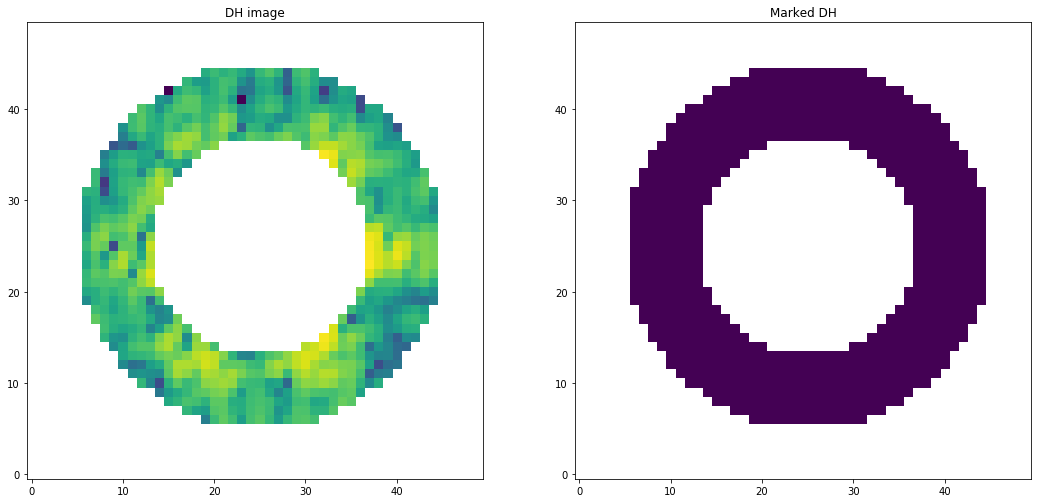

In [14]:
# Testing what area the mean is taken of
test_dh = np.copy(all_dhs[imnum1])
test_dh[np.where(test_dh != 0)] = 10000

zoomim = 25

plt.figure(figsize=(18, 9))
plt.subplot(1, 2, 1)
plt.imshow(util.zoom_cen(all_dhs[imnum1], zoomim), norm=LogNorm(), origin='lower')
plt.title('DH image')
plt.subplot(1, 2, 2)
plt.imshow(util.zoom_cen(test_dh, zoomim), norm=LogNorm(), origin='lower')
plt.title('Marked DH')
plt.show()

In [15]:
count_test = np.count_nonzero(test_dh)
count_dh = np.count_nonzero(all_dhs[imnum1])
print('Number of pixels in marked array:', count_test)
print('Number of pixels in DH array:', count_dh)
print('Mean in marked array:', np.sum(test_dh)/count_test)
print('Mean in DH array:', np.sum(all_dhs[imnum1])/count_dh)

Number of pixels in marked array: 808
Number of pixels in DH array: 808
Mean in marked array: 10000.0
Mean in DH array: 8.02914080226e-08


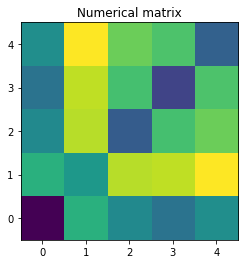

In [16]:
# Display the matrix
plt.imshow(matrix_direct, origin='lower')
plt.title('Numerical matrix')
plt.show()

In [30]:
print(matrix_direct)

[[  3.71436191e-08   8.86339898e-08   7.57455341e-08   6.80911565e-08
    7.72405774e-08]
 [  8.86339898e-08   8.02914080e-08   1.09573099e-07   1.10603396e-07
    1.18249204e-07]
 [  7.57455341e-08   1.09573099e-07   6.07133085e-08   9.44618502e-08
    1.00077925e-07]
 [  6.80911565e-08   1.10603396e-07   9.44618502e-08   5.38174632e-08
    9.56193007e-08]
 [  7.72405774e-08   1.18249204e-07   1.00077925e-07   9.56193007e-08
    6.24125997e-08]]


### Calculating the off-axis elements

Analogous to the off-axis elements in the analytical matrix (see notebook: **6_Testing analytical matrix generation**), we need to correct the off-axis elements.

In [ ]:
# I think I need to do the same thing here for the off-axis elements
# like for the analytical matrix.

## Displaying the results from the integrated script on the repo

In [54]:
# Read the matrix
filename_matrix = 'PASTISmatrix_num_' + zern_mode.name + '_' + zern_mode.convention + str(zern_mode.index)
matrix = fits.getdata(os.path.join(resDir, filename_matrix + '.fits'))

# Read the PSFs
psf_cube = fits.getdata(os.path.join(resDir, 'psfs', 'psf_cube' + '.fits'))

# Read the DH images
dh_cube = fits.getdata(os.path.join(resDir, 'darkholes', 'dh_cube' + '.fits'))

# Read the contrasts
con = np.loadtxt(os.path.join(resDir, 'contrasts.txt'))

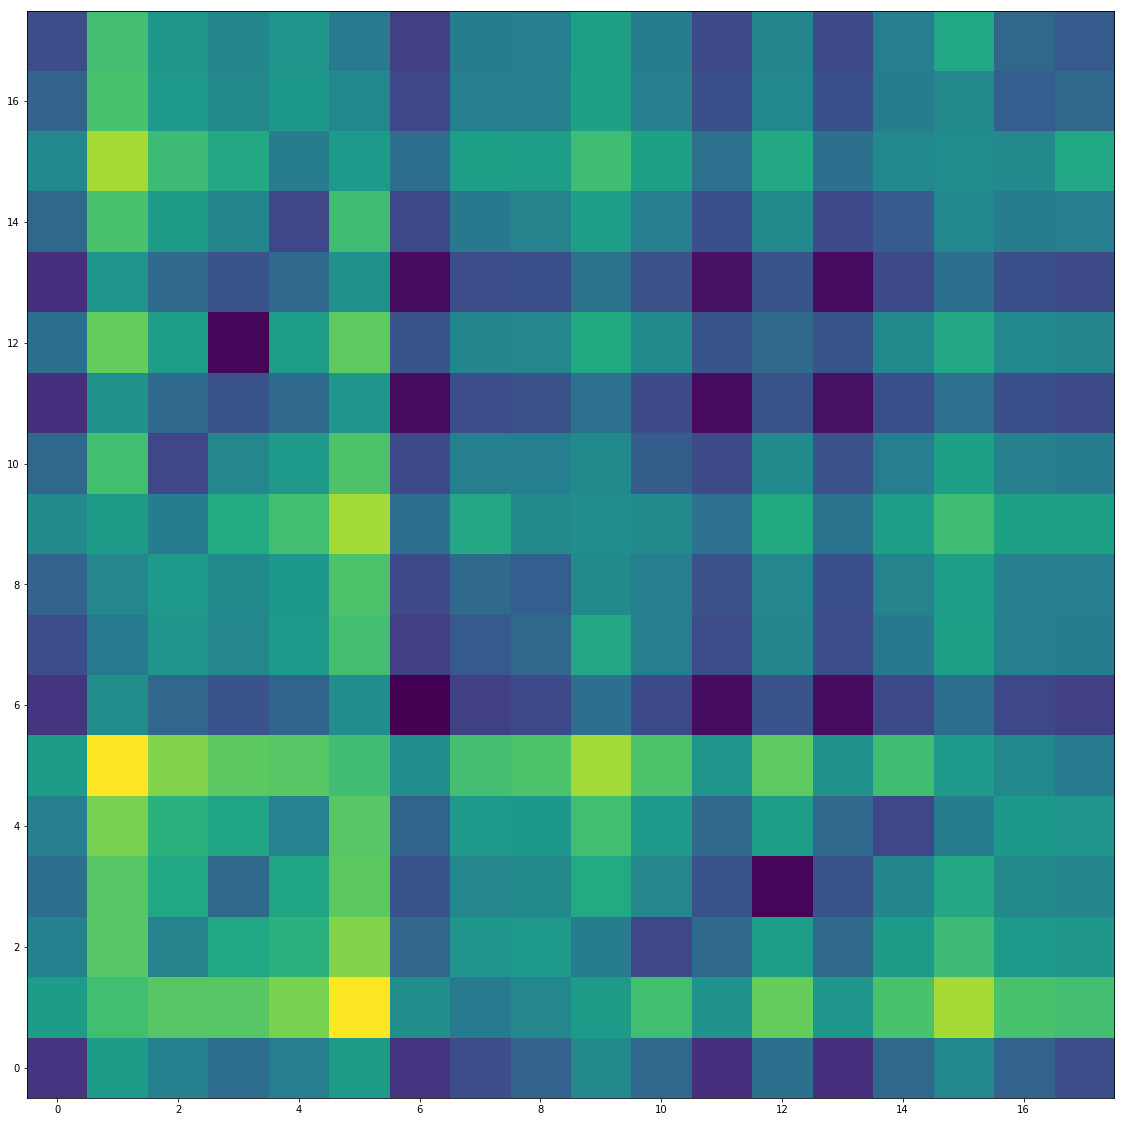

In [55]:
# Display numerical matrix
plt.figure(figsize=(20, 20))
plt.imshow(matrix, origin='lower')
plt.show()

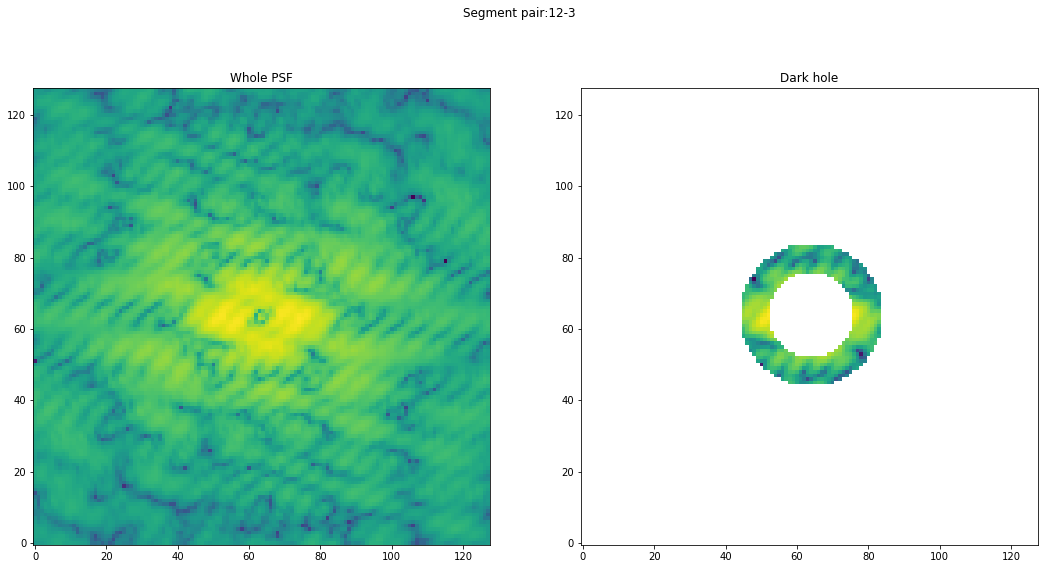

In [61]:
# You can flick through the images here
nb_seg = 18   # this has to be the same number like in the script you ran
imnum2 = 200

# Figure out what segment pair the number "imnum" corresponds ro
seg1 = int(np.floor(imnum2/nb_seg)) + 1
seg2 = imnum2%nb_seg + 1

plt.figure(figsize=(18, 9))
plt.suptitle('Segment pair:' + str(seg1) + '-' + str(seg2))
plt.subplot(1, 2, 1)
plt.imshow(psf_cube[imnum2], norm=LogNorm(), origin='lower')
plt.title('Whole PSF')
plt.subplot(1, 2, 2)
plt.imshow(dh_cube[imnum2], norm=LogNorm(), origin='lower')
plt.title('Dark hole')
plt.show()